 Случайность заключается в обучении базовых алгоритмов на разных подвыборках обучающей выборки.
 - T независимых алгоритмов, используя всего одну обучающую выборку

В методе случайного леса в каждой вершине j-й признак выбирается из случайного подмножества всего пространства признаков размера m, которое каждый раз выбирается заново

* в задачах классификации рекомендуется брать m = sqrt(d), где  d -  общее число признаков, и строить дерево до тех пор, пока в каждом листе не останется по одному объекту
* в задаче регрессии принимать m = d/3 и строить дерево, пока в листьях не останется по пять объектов



In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

from collections import Counter

import numpy as np

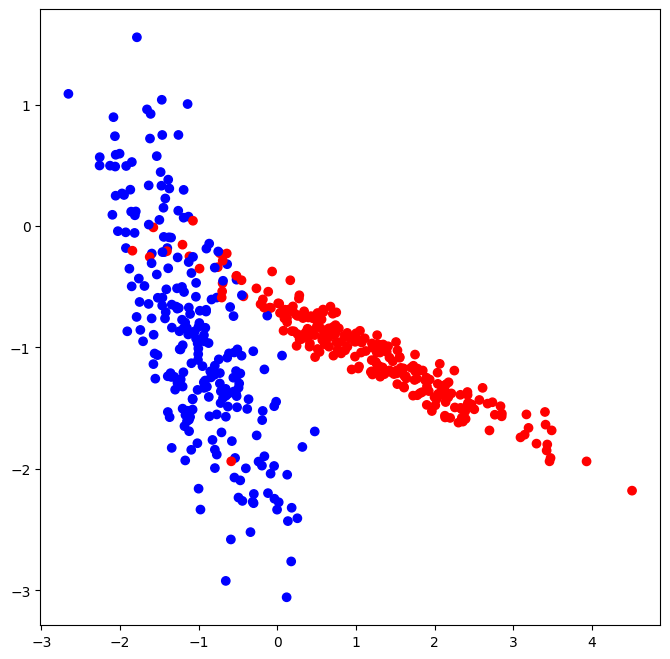

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 2-мя признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=23)

# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors);

In [3]:
classification_data.shape[0]

500

In [4]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []

    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)

        # здесь надо генерировать bootstrap выборки
        #replace - Default is True, meaning that a value of a can be selected multiple times
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        b_data[:] = data[indices]
        b_labels[:] = labels[indices]

        bootstrap.append((b_data, b_labels))

    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]

    len_subsample = int(np.sqrt(len_sample)) #сколько точек поменять в выборке
    subsample = []

    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return subsample

In [7]:
# Класс узла
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# Класс терминального узла (листа)
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        # Возвращаем наиболее частый класс в листе
        counter = Counter(self.labels)
        prediction = max(counter, key=counter.get)
        return prediction

Критерий Джини (индекс Джини)

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$ - будет характеризовать вероятность выдачи класса k

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}),$$
Его минимум достигается, когда все объекты в подмножестве относятся к одному классу, максимум — при равном содержании объектов всех классов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.

In [8]:
# Расчёт критерия Джини
def gini(labels):
    counter = Counter(labels)
    impurity = 1 - sum((count / len(labels)) ** 2 for count in counter.values())
    return impurity

#примесь Джини, равная 0, является наилучшим возможным вариантом - вероятность ошибки случайного классификатора

Функционал качества

$$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$

где X_{m} — множество объектов, попавших в лист на этом шаге, а
 и
 — {|X_{l} {|X_{r} множества, попадающие в левое и правое поддерево, соответственно, после гипотетического разбиения. {H(X)} — критерий информативности. Он оценивает качество распределения объектов в подмножестве и тем меньше, чем меньше разнообразие ответов в , соответственно, задача обучения состоит в его минимизации и максимизации
 на этом шаге.

In [9]:
# Расчёт качества
def quality(left_labels, right_labels, current_gini):
    p_l = len(left_labels) / (len(left_labels) + len(right_labels))
    p_r = len(right_labels) / (len(left_labels) + len(right_labels))
    return current_gini - p_l * gini(left_labels) - p_r * gini(right_labels)

In [11]:
# Разбиение выборки на две части
def split(data, labels, index, t): # t - порог

    true_data = data[data[:, index] >= t] #передеаем параметры
    false_data = data[data[:, index] < t]

    true_labels = labels[data[:, index] >= t] #передаем классы
    false_labels = labels[data[:, index] < t]

    return true_data, false_data, true_labels, false_labels

In [12]:
def find_best_split(data, labels):

    best_quality = -1
    best_t = None
    best_index = None
    current_gini = gini(labels)

    # Минимальное количество объектов в листе
    min_leaf = 1

    for index in range(data.shape[1]):  # Перебор всех признаков
        t_s = np.unique(data[:, index])  # Уникальные значения признака

        for t in t_s:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if len(true_labels) < min_leaf or len(false_labels) < min_leaf:
              continue

            q = quality(true_labels, false_labels, current_gini)

            if q > best_quality:
                best_quality, best_t, best_index = q, t, index

    return best_quality, best_t, best_index


In [13]:
# Построение дерева посредством рекурсивной функции
def build_tree(data, labels):
    best_quality, best_t, best_index = find_best_split(data, labels)

    if best_quality < 0:  # если разбиение невозможно
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, best_index, best_t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    return Node(best_index, best_t, true_branch, false_branch)

In [14]:
def random_forest(data, labels, n_trees):
    forest = []

    bootstrap = get_bootstrap(data, labels, n_trees)
    # n_trees бутстрэп - выборок из данных и меток
    # Каждая выборка будет использоваться для обучения одного дерева

    # строим лес
    # b_data - параметры
    # b_labels - классы

    for b_data, b_labels in bootstrap:
        tree = build_tree(b_data, b_labels)
        forest.append(tree)

    return forest

In [19]:
# Функция классификации отдельного объекта
def classify_object(obj, node):
  if isinstance(node, Leaf): #если лист, то конец - результат - к какому классу лист принадлежит
    return node.prediction

  if obj[node.index] >= node.t:
    return classify_object(obj, node.true_branch)
  else:
    return classify_object(obj, node.false_branch)

In [20]:
# Функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
  return [classify_object(obj, tree) for obj in data]
  # для каждого obj в data возвращаем к какому классу он принадлежит именно для этого tree

In [41]:
# предсказание голосованием деревьев
def tree_vote(forest, data):

    predictions = np.array([predict(data, tree) for tree in forest])
    # отправляем data в каждый tree из forest и получаем

    voted_predictions = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
    return voted_predictions

In [17]:
# Разобьем выборку на обучающую и тестовую
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [21]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
      if actual[i] == predicted[i]:
        correct += 1

    return correct / float(len(actual)) * 100.0

In [43]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_1, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 96.857
Точность случайного леса из 1 деревьев на тестовой выборке: 90.667


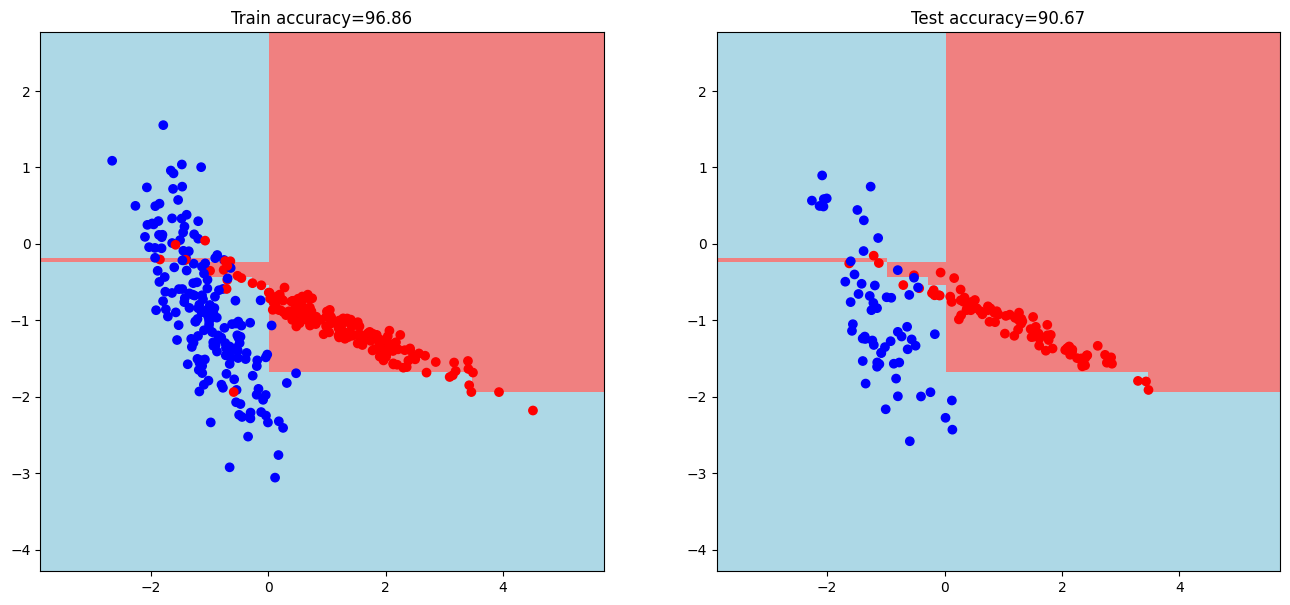

In [44]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

In [50]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_3, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 97.429
Точность случайного леса из 3 деревьев на тестовой выборке: 93.333


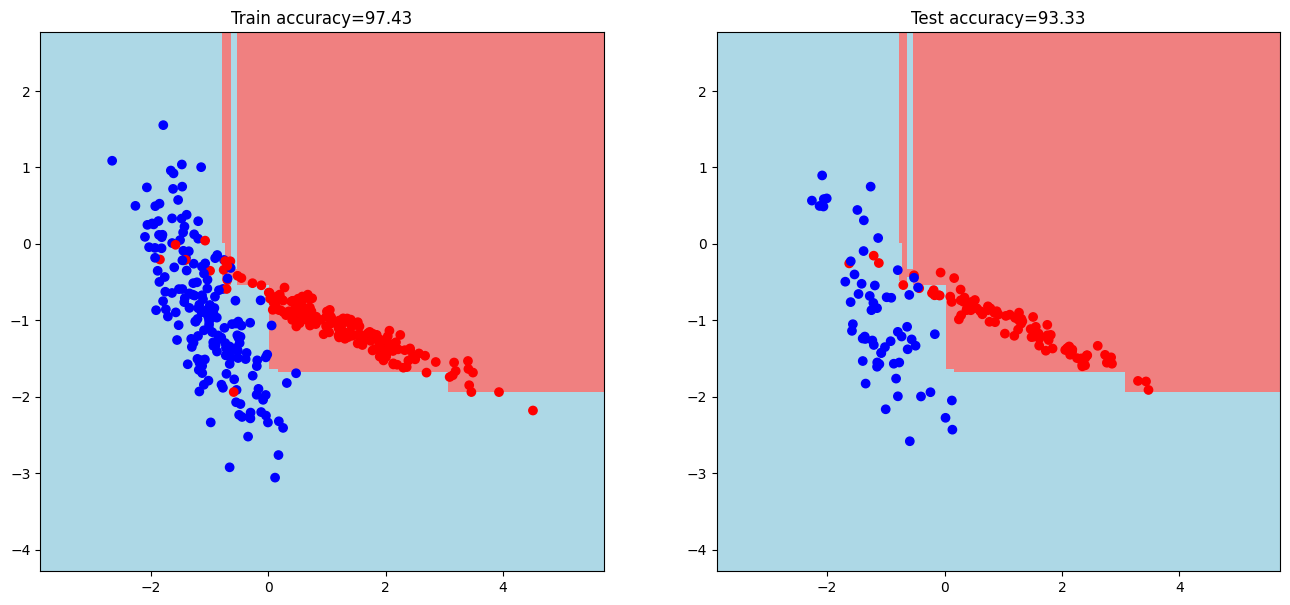

In [51]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

In [57]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_10, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.857
Точность случайного леса из 10 деревьев на тестовой выборке: 92.667


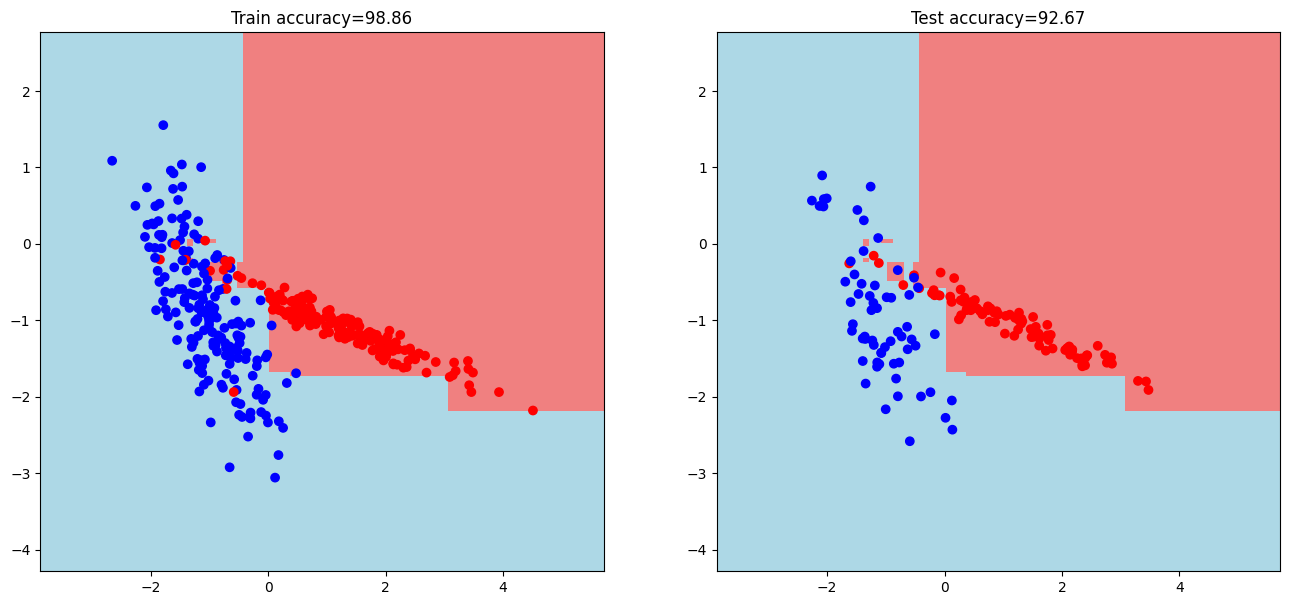

In [58]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()

In [59]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

# Получим ответы для обучающей выборки
train_answers = tree_vote(my_forest_50, train_data)

# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 93.333


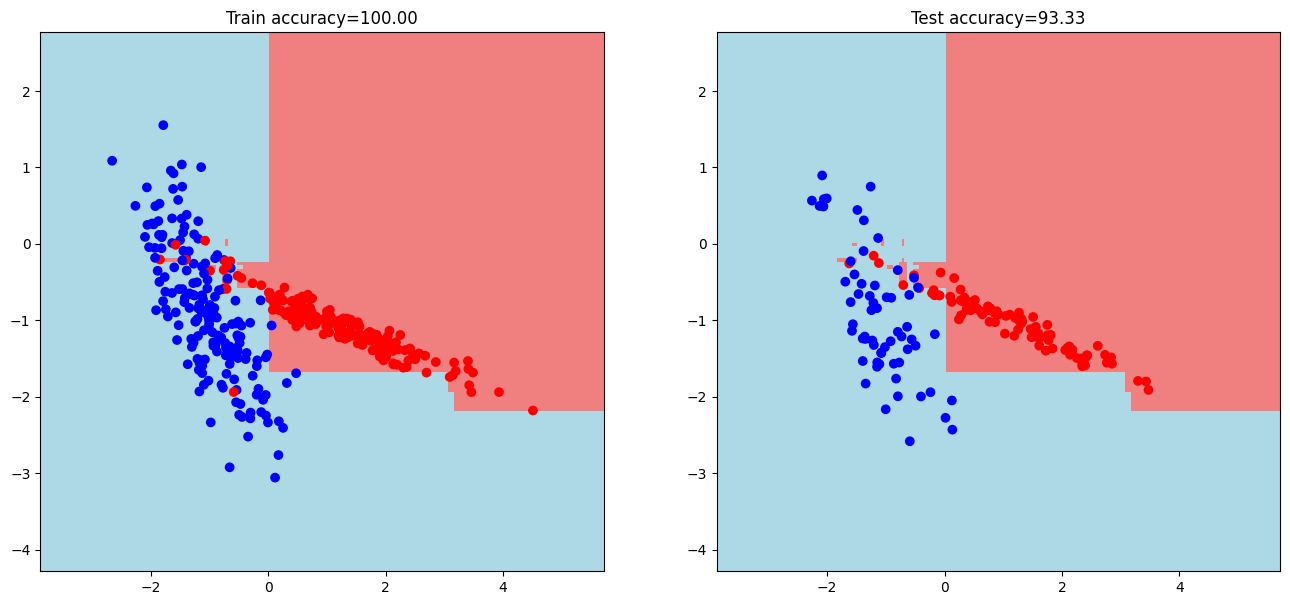

In [61]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)

mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.show()